# Import necessary packages

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from collections import Counter
from imblearn.over_sampling import SMOTE
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# Data preprocessing

In [2]:
df = pd.read_csv("../data/clean_merged.csv")
df.head()

,id,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,name_income_type,name_education_type,name_family_status,name_housing_type,...,cnt_fam_members,age,is_employed,years_employed,amt_income_log,max_delay,avg_delay,num_bad_months,months_total,label
0,5008804,1,1,1,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,...,2,32,1,12.435318,12.965712,1,0.000000,0,16,0
1,5008805,1,1,1,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,...,2,32,1,12.435318,12.965712,1,0.000000,0,15,0
2,5008806,1,1,1,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,...,2,58,1,3.104723,11.630717,0,-0.533333,0,30,0
3,5008808,0,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,...,1,52,1,8.353183,12.506181,0,-0.600000,0,5,0
4,5008809,0,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,...,1,52,1,8.353183,12.506181,-1,-1.000000,0,5,0


In [3]:
leaky_features = ['max_delay', 'avg_delay', 'num_bad_months', 'months_total']
X = df.drop(columns=['label', 'id', 'amt_income_total'] + leaky_features)
y = df['label'].astype('int')

In [4]:
categorical_cols = X.select_dtypes(include=['object', 'category']).columns
if len(categorical_cols) > 0:
    X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)
else:
    X_encoded = X

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size = 0.2, random_state = 42, stratify = y)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
Counter(y_train), Counter(y_test) #check class distribution

(Counter({0: 28672, 1: 493}), Counter({0: 7169, 1: 123}))

In [6]:
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

In [7]:
smote = SMOTE(random_state = 42)
X_balance, y_balance = smote.fit_resample(X_train_scaled, y_train)
Counter(y_balance)

Counter({0: 28672, 1: 28672})

In [8]:
X_train_tensor = torch.tensor(X_balance, dtype=torch.float32)
y_train_tensor = torch.tensor(y_balance.values, dtype=torch.float32).unsqueeze(1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True) #create dataloader for mini batch training 

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=64)

# Neural Network set up

In [9]:
#Do 3 layers of NN with ReLU activation and sigmoid output for binary classification
class NN(nn.Module):
    def __init__(self, input_dim, hidden_layers = 64):
        super().__init__()
        self.layer1 = nn.Linear(input_dim, hidden_layers)
        self.act1 = nn.ReLU()

        self.layer2 = nn.Linear(hidden_layers, hidden_layers)
        self.act2 = nn.ReLU()

        self.layer3 = nn.Linear(hidden_layers, hidden_layers)
        self.act3 = nn.ReLU()

        self.output = nn.Linear(hidden_layers, 1)

    def forward(self, x):
        x = self.layer1(x)
        x = self.act1(x)

        x = self.layer2(x)
        x = self.act2(x)

        x = self.layer3(x)
        x = self.act3(x)

        x = self.output(x)
        x = torch.sigmoid(x)
        return x

## Training

In [12]:
input_dim = X_train_tensor.shape[1] #get number of features
nn_base_model = NN(input_dim)

#configuration
criterion = nn.BCELoss()  
optimizer = optim.Adam(nn_base_model.parameters(), lr=0.0001)
epochs = 100
train_losses = []
val_losses = []
test_losses = []
test_accuracies = []

In [13]:
for epoch in range(epochs):
    nn_base_model.train()
    epoch_loss = 0.0
    
    for X_batch, Y_batch in train_loader:
        optimizer.zero_grad()
        predictions = nn_base_model(X_batch)
        loss = criterion(predictions, Y_batch.float())
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    avg_train_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    nn_base_model.eval()
    total_test_loss = 0
    correct_predictions = 0
    total_samples = 0
    
    with torch.no_grad():
        for X_batch, Y_batch in test_loader:
            predictions = nn_base_model(X_batch)
            loss = criterion(predictions, Y_batch.float())
            total_test_loss += loss.item()

            predicted_classes = (predictions >= 0.5).float()
            correct_predictions += (predicted_classes == Y_batch).sum().item()
            total_samples += len(Y_batch)
    
    avg_test_loss = total_test_loss / len(test_loader)
    test_accuracy = correct_predictions / total_samples

    test_losses.append(avg_test_loss)
    test_accuracies.append(test_accuracy)
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Epoch 1/100, Train Loss: 0.6751, Test Loss: 0.6792, Test Accuracy: 0.5362
Epoch 2/100, Train Loss: 0.5917, Test Loss: 0.5099, Test Accuracy: 0.7562
Epoch 3/100, Train Loss: 0.4977, Test Loss: 0.4749, Test Accuracy: 0.7663
Epoch 4/100, Train Loss: 0.4266, Test Loss: 0.4752, Test Accuracy: 0.7637
Epoch 5/100, Train Loss: 0.3779, Test Loss: 0.3818, Test Accuracy: 0.8279
Epoch 6/100, Train Loss: 0.3420, Test Loss: 0.3854, Test Accuracy: 0.8280
Epoch 7/100, Train Loss: 0.3131, Test Loss: 0.3072, Test Accuracy: 0.8742
Epoch 8/100, Train Loss: 0.2891, Test Loss: 0.2707, Test Accuracy: 0.8959
Epoch 9/100, Train Loss: 0.2685, Test Loss: 0.2902, Test Accuracy: 0.8888
Epoch 10/100, Train Loss: 0.2511, Test Loss: 0.3657, Test Accuracy: 0.8508
Epoch 11/100, Train Loss: 0.2357, Test Loss: 0.3120, Test Accuracy: 0.8758
Epoch 12/100, Train Loss: 0.2216, Test Loss: 0.3031, Test Accuracy: 0.8793
Epoch 13/100, Train Loss: 0.2112, Test Loss: 0.3356, Test Accuracy: 0.8572
Epoch 14/100, Train Loss: 0.2003, 

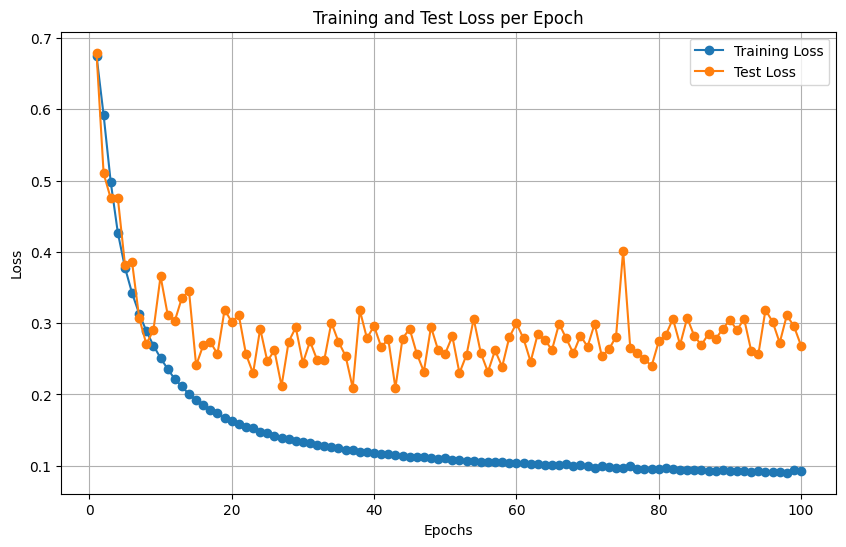

In [15]:
num_epochs_run = len(train_losses)
plt.figure(figsize=(10, 6))

plt.plot(range(1, num_epochs_run + 1), train_losses, marker='o', label='Training Loss')
plt.plot(range(1, num_epochs_run + 1), test_losses, marker='o', label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss per Epoch')
plt.legend()
plt.grid(True)
plt.show()

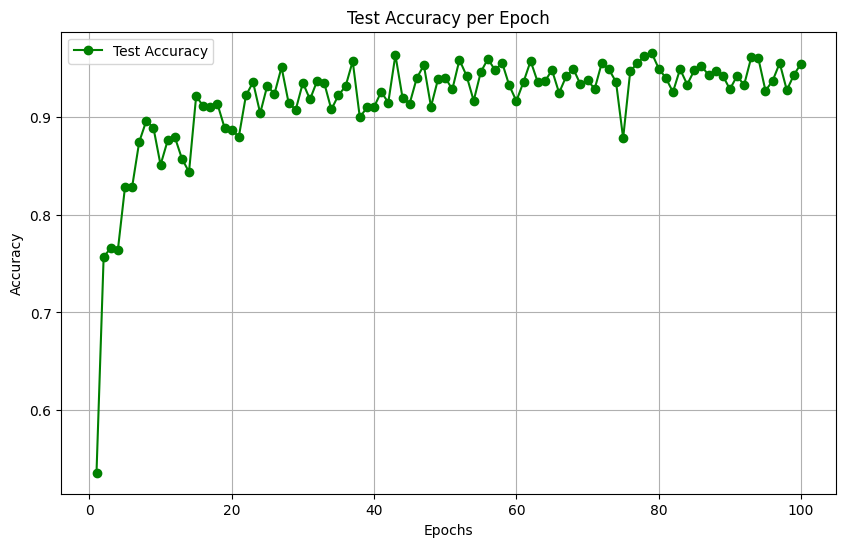

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs_run + 1), test_accuracies, marker='o', label='Test Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Test Accuracy per Epoch')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
y_pred = []
y_true = []

nn_base_model.eval()
with torch.no_grad():
    for X_batch, Y_batch in test_loader:
        predictions = nn_base_model(X_batch).squeeze()
        predicted_classes = (predictions >= 0.5).float()

        y_pred.extend(predicted_classes.cpu().numpy())
        y_true.extend(Y_batch.cpu().numpy())
y_pred = np.array(y_pred)
y_true = np.array(y_true)
print("\nClassification Report:")
print(classification_report(y_true, y_pred))
print("AUC Base Model Score:", roc_auc_score(y_true, y_pred))


Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98      7169
         1.0       0.13      0.29      0.18       123

    accuracy                           0.95      7292
   macro avg       0.56      0.63      0.58      7292
weighted avg       0.97      0.95      0.96      7292

AUC Base Model Score: 0.6291842587835837
